In [37]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data
!pip -qqq install tqdm

--2022-04-18 00:14:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11903 (12K) [application/x-httpd-php]
Saving to: ‘glass.data.2’

glass.data.2        100%[===================>]  11.62K  --.-KB/s    in 0s      

2022-04-18 00:14:59 (133 MB/s) - ‘glass.data.2’ saved [11903/11903]



# Objetivo do exercício:

* Implementar do zero o pipeline de treinamento em ML.
  * Carregamento dos dados
  * Pré-processamento dos dados
  * Instanciação do modelo  
  * Setup de parâmetros
  * Treinamento 
  * Avaliação do modelo treinado

* Plotar o dataset usando a Análise de componentes Principais (PCA) para redução de dimensionalidade. Responda por escrito em seu notebook:
  * As instâncias de classes diferentes estão visualmente bem separadas?
  * O que essa configuração da distribuição sugere sobre a dificuldade ou facilidade de um classificador qualquer em categorizar corretamente as instâncias?

* O dataset utilizado será o Glass. Seu link está logo abaixo.

* Treinar com duas versões diferentes de Modelo Bayesiano, a seu critério, considerando as implementações do scikit. Justificar o uso dos modelos;

* Utilizar a medida de precisão para avaliar o modelo.

# Lendo a base de dados do glass:

*   Descrição da base: https://archive.ics.uci.edu/ml/datasets/glass+identification

* Colunas:

1. Id number: 1 to 214
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
-- 1 building_windows_float_processed

-- 2 building_windows_non_float_processed

-- 3 vehicle_windows_float_processed

-- 4 vehicle_windows_non_float_processed (none in this database)

-- 5 containers

-- 6 tableware

-- 7 headlamps

In [38]:
import pandas as pd
from google.colab import data_table

columns = "id,ri,na,mg,ai,si,k,ca,ba,fe,class".split(",")
df = pd.read_csv("glass.data", header=None)
df.columns = columns

data_table.DataTable(df, include_index=False, num_rows_per_page=10)

,id,ri,na,mg,ai,si,k,ca,ba,fe,class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
209,210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


# Separando os atributos (features) e a classe

* O campo id (identificador único) deve ser descartado.

In [39]:
X = df.drop(["id", "class"], axis = 1).to_numpy()
y = df["class"].values

# Pré-processando 

## Recodificando os rótulos (classes)

* De maneira geral precisamos mapear as classes de valores textuais para valores numérico-categóricos.
* Para este dataset, entretanto, não é necessário, uma vez que as classes estão apresentadas como números.
* Ou seja, você não precisa fazer nada nesta etapa :)

## Plotando o dataset

* As classes dos elementas deve ser destacadas por cores
* Usamos a técnica de Análise de Componentes Principais para reduzir as dimensões

In [40]:
# usando plotly pra plotar o gráfico
%matplotlib inline
import matplotlib.pyplot as pl
import seaborn as sb
from sklearn import preprocessing
from sklearn.decomposition import PCA

p = PCA(n_components = 2)
x_p = p.fit_transform(preprocessing.maxabs_scale(X))
pl.style.use('ggplot')

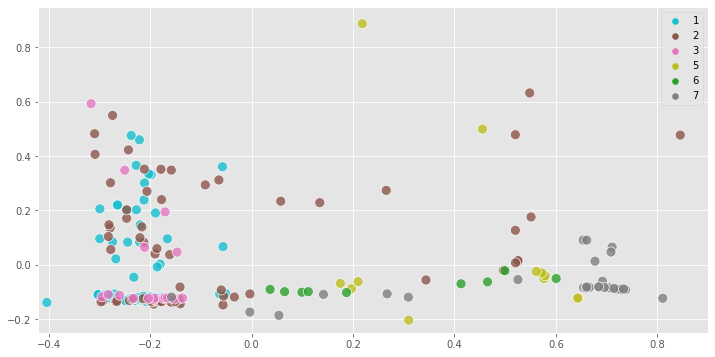

In [41]:
# escolhendo paleta de cores
palette = ['tab:cyan', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:green', 'tab:gray']
pl.figure(figsize = (12, 6))
sb.scatterplot(x = x_p[:, 0], y = x_p[:, 1], s = 100, hue = y, palette = palette, alpha = 0.8)

# setando dimensões do gráfico
pl.xlim(-0.42, 0.9)
pl.ylim(-0.25, 0.95)
pl.legend()
pl.show()

## Dividindo a base em treino, teste e validação

In [42]:
# setando seed (botei meio aleatorio msm), puxando biblio de split test e dividindo as bases
from sklearn.model_selection import train_test_split

SEED = 820

x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20,
                                                    random_state = SEED,
                                                    stratify = y)

x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train,
                                                      test_size = 0.20,
                                                      random_state = SEED,
                                                      stratify = y_train)

## Padronizando separadamente as bases

In [43]:
# preprocessando os sets de treinamento, teste e validação
x_train = preprocessing.minmax_scale(x_train)
x_test = preprocessing.minmax_scale(x_test)
x_valid = preprocessing.minmax_scale(x_valid)

# Instanciando o modelo



In [44]:
# importando gaussian e multinomial
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Validação do modelo

* Validar testando diferentes valores do *var_smoothing*.
* Considerar o espaço de busca para o *var_smoothing* considerado abaixo. 

In [45]:
import numpy as np
np.set_printoptions(suppress=True)
search_space = np.linspace(1e-12,1, 10)
search_space

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [46]:
# puxando do sklearn as métricas para os cálculos de precisão

from sklearn.metrics import precision_score

gnb_vscores = []
mnb_vscores = []
i = 0

for smoothing in search_space:

  i+=1

  # Gaussian
  mGNB = GaussianNB(var_smoothing = smoothing)
  mGNB.fit(x_train, y_train)

  # fazendo a predição
  gnb_train_p = mGNB.predict(x_train)
  gnb_valid_p = mGNB.predict(x_valid)

  # setando valores de treino e validação para gaussian
  train_score_gnb = precision_score(y_train, gnb_train_p, average="micro")
  validation_score_gnb = precision_score(y_valid, gnb_valid_p, average="micro")

  # fazendo append dos valores de validação com gaussian nesse array pra usar na etapa de avaliação
  gnb_vscores.append(validation_score_gnb)

  # Multinomial
  mMNB = MultinomialNB(alpha = smoothing)
  mMNB.fit(x_train, y_train)

  # fazendo a predição 
  mnb_train_p = mMNB.predict(x_train)
  mnb_valid_p = mMNB.predict(x_valid)

  # setando valores de treino e validação para multinomial
  train_score_mnb = precision_score(y_train, mnb_train_p, average="micro")
  validation_score_mnb = precision_score(y_valid, mnb_valid_p, average="micro") 

  # fazendo append dos valores de validação com multinomial nesse array pra usar na etapa de avaliação
  mnb_vscores.append(validation_score_mnb)
  
  print("Etapa", i)
  print("Valor de suavização -> " f"{smoothing:.2f}")
  print("Pontuação nos treinos com GaussianNB ->", f"{train_score_gnb:.3f}")
  print("Pontuação de teste com GaussianNB ->", f"{validation_score_gnb:.3f}")
  print("Pontuação nos treinos com MultinomialNB ->", f"{train_score_mnb:.3f}")
  print("Pontuação de teste com MultinomialNB ->", f"{validation_score_mnb:.3f}")
  print("\n")

Etapa 1
Valor de suavização -> 0.00
Pontuação nos treinos com GaussianNB -> 0.507
Pontuação de teste com GaussianNB -> 0.286
Pontuação nos treinos com MultinomialNB -> 0.515
Pontuação de teste com MultinomialNB -> 0.571


Etapa 2
Valor de suavização -> 0.11
Pontuação nos treinos com GaussianNB -> 0.566
Pontuação de teste com GaussianNB -> 0.429
Pontuação nos treinos com MultinomialNB -> 0.515
Pontuação de teste com MultinomialNB -> 0.571


Etapa 3
Valor de suavização -> 0.22
Pontuação nos treinos com GaussianNB -> 0.544
Pontuação de teste com GaussianNB -> 0.514
Pontuação nos treinos com MultinomialNB -> 0.515
Pontuação de teste com MultinomialNB -> 0.571


Etapa 4
Valor de suavização -> 0.33
Pontuação nos treinos com GaussianNB -> 0.529
Pontuação de teste com GaussianNB -> 0.514
Pontuação nos treinos com MultinomialNB -> 0.515
Pontuação de teste com MultinomialNB -> 0.571


Etapa 5
Valor de suavização -> 0.44
Pontuação nos treinos com GaussianNB -> 0.522
Pontuação de teste com Gaussia

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


# Avaliando o modelo final com os parâmetros otimizados


In [47]:
# Printando o melhor valor de acurácia no conjunto que a gente calculou acima

# com Gaussian
best_smoothing_gnb = search_space[gnb_vscores.index(max(gnb_vscores))]
m2 = GaussianNB(var_smoothing = best_smoothing_gnb)
m2.fit(x_train, y_train)

GaussianNB(var_smoothing=0.222222222223)

In [48]:
# com Multinomial
best_smoothing_mnb = search_space[mnb_vscores.index(max(mnb_vscores))]
m3 = MultinomialNB(alpha = best_smoothing_mnb)
m3.fit(x_train, y_train)

MultinomialNB(alpha=0.6666666666669999)

# Quantidade de exemplos por classes

* Buscar na referência das classes scikit como ter acesso às contagens das classes e exibí-las aqui para cada classificador usado
*GaussianNB

In [49]:
y_test_p = m2.predict(x_test)

print(y_test_p)
print(y_test)

score_test = precision_score(y_test, y_test_p, average="micro")

[1 1 5 1 7 1 1 7 1 1 5 2 2 1 2 1 7 1 2 7 1 5 5 5 5 7 1 1 1 2 1 5 1 1 1 5 5
 7 6 2 7 5 1]
[1 1 2 3 7 1 1 7 1 1 2 1 2 2 5 1 7 1 2 7 1 2 2 2 2 7 1 2 3 5 3 5 1 1 1 2 2
 7 6 2 6 2 2]


# Probabilidade à priori das classes

* A probabilidade à priori equivale à frequência relativa das classes quando não informada através do parâmetro *prios*.

* Buscar na referência das classes scikit como ter acesso às probabilidades à priori calculadas para cada classificar usado.

In [50]:
aux = np.array(y)

count = [np.count_nonzero(aux == 1), np.count_nonzero(aux == 2), np.count_nonzero(aux == 3), np.count_nonzero(aux == 4), 
         np.count_nonzero(aux == 5), np.count_nonzero(aux == 6), np.count_nonzero(aux == 7)]

finalCount = np.sum(count)

for i in range (7):
    prob_priori = round((count[i]/finalCount)*100, 1)
    print(f'A probabilidade a priori {i+1} é {prob_priori}%')

A probabilidade a priori 1 é 32.7%
A probabilidade a priori 2 é 35.5%
A probabilidade a priori 3 é 7.9%
A probabilidade a priori 4 é 0.0%
A probabilidade a priori 5 é 6.1%
A probabilidade a priori 6 é 4.2%
A probabilidade a priori 7 é 13.6%
